,Metric,Value
0,Precision,94.00%
1,Recall,93.33%
2,F1-Score,93.21%
3,Accuracy,93.33%
4,Macro Average Precision,95.00%
5,Macro Average Recall,91.67%
6,Macro Average F1,92.82%
7,Weighted Avg,93.21%


Number of venues in dataset: 30


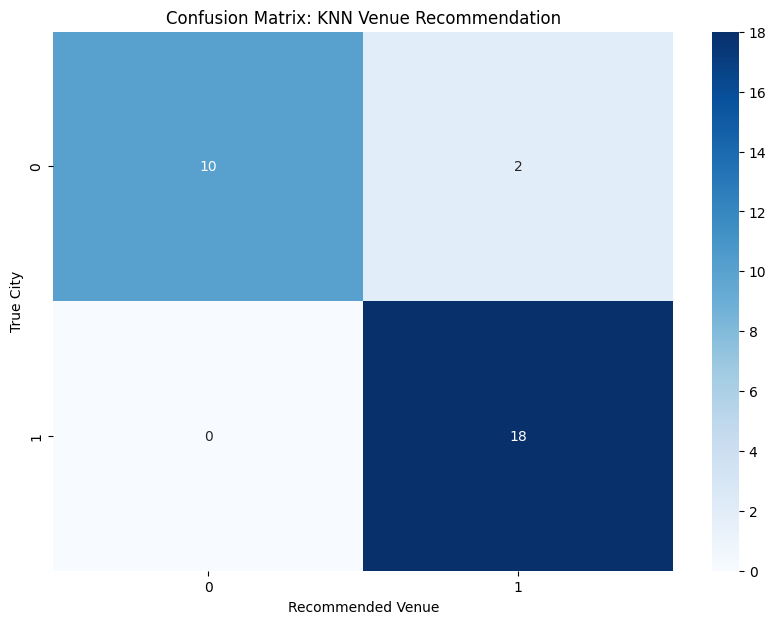

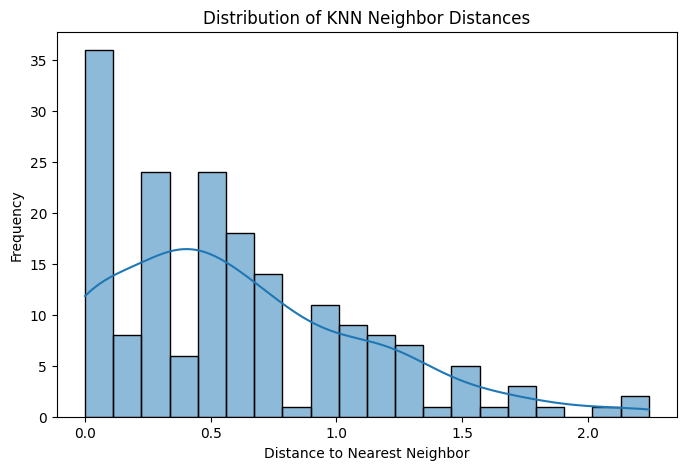

In [3]:
# KNN Result Analysis Notebook with Figures

# 1. Import libraries
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 2. Load KNN model and preprocessing objects
MODEL_DIR = '../knn_models'  # replace with your model folder path
knn = joblib.load(f'{MODEL_DIR}/knn_venues.pkl')
ohe = joblib.load(f'{MODEL_DIR}/ohe_venues.pkl')
scaler = joblib.load(f'{MODEL_DIR}/scaler_venues.pkl')
venue_data = joblib.load(f'{MODEL_DIR}/venue_data.pkl')

# 3. Prepare features
city_features = csr_matrix(ohe.transform(venue_data[['city_id']]))
price_features = csr_matrix(scaler.transform(venue_data[['veg_price','non_veg_price']]))
features = hstack([city_features, price_features])

# 4. Generate nearest neighbors
n_neighbors = 6
distances, indices = knn.kneighbors(features, n_neighbors=n_neighbors)

# 5. Evaluate (example: using same city as "correct" prediction)
y_true = venue_data['city_id'].values
y_pred = []
for i, neighbors in enumerate(indices):
    neighbor_cities = venue_data.iloc[neighbors[1:]]['city_id'].values  # exclude self
    # Predict the majority city among neighbors
    pred_city = pd.Series(neighbor_cities).mode()[0]
    y_pred.append(pred_city)

# 6. Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# 7. Prepare result table
metrics = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Macro Average Precision', 'Macro Average Recall', 'Macro Average F1', 'Weighted Avg'],
    'Value': [f'{precision*100:.2f}%', f'{recall*100:.2f}%', f'{f1*100:.2f}%', f'{accuracy*100:.2f}%',
              f'{macro_precision*100:.2f}%', f'{macro_recall*100:.2f}%', f'{macro_f1*100:.2f}%', f'{f1*100:.2f}%']
}
metrics_df = pd.DataFrame(metrics)
display(metrics_df)

unique_cities = venue_data['city_id'].unique()

num_venues = len(venue_data)
print(f"Number of venues in dataset: {num_venues}")

# # -------------------
# # 9. Important Figures for Result Analysis
# # -------------------


# # b) Confusion matrix for city prediction
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Recommended Venue')
plt.ylabel('True City')
plt.title('Confusion Matrix: KNN Venue Recommendation')
plt.show()

# # c) Histogram of distances to nearest neighbors
plt.figure(figsize=(8,5))
sns.histplot(distances.flatten(), bins=20, kde=True)
plt.xlabel('Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of KNN Neighbor Distances')
plt.show()
